# MoA+ VS. Hinton MoE (MILTECH dataset)

## 1. Setup

In [44]:
import os
import abc
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm 
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import normalized_mutual_info_score, mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, UpSampling2D, Reshape

In [45]:
NUM_CLUSTERS = 2
EPOCHS_HINTON = 100
EPOCHS_MOA_PLUS = EPOCHS_HINTON
BATCH_SIZE = 256       
IMAGE_SHAPE = (28, 28, 1)
LEARNING_RATE = 1e-3

SEED = 21
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2. Load Dataset

Processed 1000/2067 files
Processed 2000/2067 files
Processed 2067/2067 files
Finished loading. Found 2067 images.
Images shape: (2067, 28, 28, 1)
Labels shape: (2067,)
Processed 487/487 files
Finished loading. Found 487 images.
Images shape: (487, 28, 28, 1)
Labels shape: (487,)


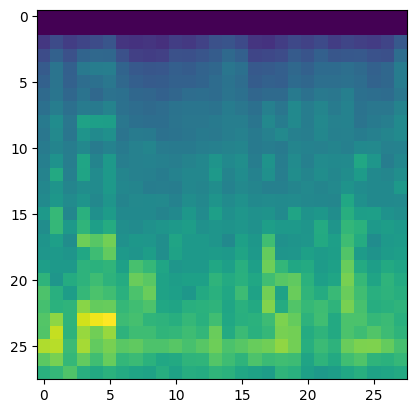

In [46]:
TRAIN_DIR = "/kaggle/input/comm-vs-gun/training_melspectrogram_images_28x28_smaller"
TEST_DIR = "/kaggle/input/comm-vs-gun/test_melspectrogram_images_28x28_smaller"


def load_and_preprocess_data(data_dir):
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return None, None

    images = []
    labels = []

    filenames = os.listdir(data_dir)
    total_files = len(filenames)

    for i, filename in enumerate(filenames):
        if filename.endswith('.png'):
            filepath = os.path.join(data_dir, filename)

            parts = filename.split('_')
            if len(parts) == 2 and 'label' in parts[1]:
                try:
                    label_part = parts[1].split('.')[0]
                    label = int(label_part.replace('label', ''))
                except ValueError:
                    print(f"Skipping file with invalid label format: {filename}")
                    continue
            else:
                print(f"Skipping file with unexpected name format: {filename}")
                continue

        
            try:
                img = Image.open(filepath)

                # Convert to grayscale if TARGET_CHANNELS is 1
                TARGET_CHANNELS = IMAGE_SHAPE[-1]
                if  TARGET_CHANNELS == 1:
                    img = img.convert('L')
                    
                img = img.resize(IMAGE_SHAPE[:2])
                img_array = np.array(img)

                if TARGET_CHANNELS == 1 and img_array.ndim == 2:
                     img_array = np.expand_dims(img_array, axis=-1)

                img_array = img_array / 255.0

                images.append(img_array)
                labels.append(label)

                if (i + 1) % 1000 == 0 or (i + 1) == total_files:
                    print(f"Processed {i + 1}/{total_files} files")

            except Exception as e:
                print(f"Error loading or processing {filename}: {e}")
                

    images_np = np.array(images)
    labels_np = np.array(labels)

    print(f"Finished loading. Found {len(images)} images.")
    print(f"Images shape: {images_np.shape}")
    print(f"Labels shape: {labels_np.shape}")

    return images_np, labels_np

x_train, y_train = load_and_preprocess_data(TRAIN_DIR)
x_test, y_test = load_and_preprocess_data(TEST_DIR)

plt.imshow(x_train[-1])

## 3. Models

### 3.1 Hinton MoE

In [47]:
def build_expert(input_tensor):
    """ Conv Autoencoder. """
    # Encoder
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_tensor)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Flatten()(x)
    latent_space = Dense(16, activation="relu")(x)

    # Decoder
    x = Dense(4 * 4 * 8, activation="relu")(latent_space)
    x = Reshape((4, 4, 8))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="valid")(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return outputs


def build_gate(M, input_tensor):
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_tensor)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Flatten()(x)
    x = Dense(M, activation='softmax')(x)

    return x

class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters):
        super().__init__()
        self.input_dim = input_dim
        self.num_experts = num_clusters  # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]  # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs)  # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)
                # (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        outputs = build_expert(inputs)
        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        gate = build_gate(self.num_experts, inputs)
        model = tf.keras.Model(inputs=inputs, outputs=gate)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)


hinton_model = MixtureOfExperts(IMAGE_SHAPE, NUM_CLUSTERS)
hinton_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss='mse') 
hinton_model.summary() 

print(f"Training Hinton model for {EPOCHS_HINTON} epochs...")
hinton_history = hinton_model.fit(
    x_train, x_train, 
    epochs=EPOCHS_HINTON,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    verbose=1 # Show progress
)

Model: "mixture_of_experts_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_21 (Functional)           │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_22 (Functional)           │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_23 (Functional)           │ (None, 2)                   │           1,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,076 (62.80 KB)

 Trainable params: 16,076 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

Training Hinton model for 100 epochs...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - loss: 0.0551 - val_loss: 0.0542
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0522 - val_loss: 0.0465
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.0438 - val_loss: 0.0372
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.0348 - val_loss: 0.0286
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0275 - val_loss: 0.0240
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0200 - val_loss: 0.0186
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0185 - val_loss: 0.0173
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 12/100
9/9 ━━━━━

### 3.2 MoA+

In [48]:
class MoA_plus(tf.keras.Model):
    def __init__(self, input_dim, num_clusters, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert(k) for k in range(self.num_experts)]
        self.gate = self.build_gate()

        # Trainable variable for the 1/lambda_k^2 terms.
        # Initialize to ones. Using relu ensures non-negativity.
        # Add a small epsilon for numerical stability if needed.
        self.inv_lambda_sq_raw = self.add_weight(
            name='inv_lambda_sq_raw',
            shape=(self.num_experts,),
            initializer='ones',
            trainable=True
        )

    @property
    def inv_lambda_sq(self):
        return tf.nn.relu(self.inv_lambda_sq_raw) + tf.keras.backend.epsilon()


    def call(self, inputs, training=False):
        expert_outputs = [expert(inputs, training=training) for expert in self.experts]
        gate_output = self.gate(inputs, training=training)

        gate_output_reshaped = tf.reshape(gate_output, [-1, 1, 1, 1, self.num_experts])
        expert_outputs_stacked = tf.stack(expert_outputs, axis=-1)
        weighted_expert_outputs = expert_outputs_stacked * gate_output_reshaped
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=-1)
        return aggregated_output

    def build_expert(self, expert_index):
        """ Builds a single expert model. """
        inputs = Input(shape=self.input_dim)
        outputs = build_expert(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'expert_{expert_index}')
        return model

    def build_gate(self):
        """ Builds the gating model. """
        inputs = Input(shape=self.input_dim)
        gate_outputs = build_gate(self.num_experts, inputs)
        model = tf.keras.Model(inputs=inputs, outputs=gate_outputs, name='gate')
        return model

    def train_step(self, data):
        if isinstance(data, tuple):
            x, y_true = data
        else:
            x = data
            y_true = x

        with tf.GradientTape() as tape:
            expert_outputs = [expert(x, training=True) for expert in self.experts]
            gate_output = self.gate(x, training=True) # These are p_{i:n}^k

            # L = term1 * term2
            # term1 = sqrt( sum_k (1 / lambda_k^2) )
            # term2 = sqrt( sum_k [ (sum_i p_ik * (X_i - Xhat_ik)^2) ]^2 )

            # Calculate term1
            term1 = tf.sqrt(tf.reduce_sum(self.inv_lambda_sq))

            # Calculate term2
            inner_sum_sq_terms = []
            for k in range(self.num_experts):
                x_hat_k = expert_outputs[k]
                p_k = gate_output[:, k]

                # Calculate pixel-wise squared error: (X_i - Xhat_ik)^2
                pixel_sq_error = tf.square(y_true - x_hat_k)
                sample_sq_error = tf.reduce_sum(pixel_sq_error, axis=[1, 2, 3])
                weighted_sum_k = tf.reduce_sum(p_k * sample_sq_error) # Scalar
                inner_sum_sq_terms.append(tf.square(weighted_sum_k))

            sum_inner_sq = tf.reduce_sum(tf.stack(inner_sum_sq_terms))
            term2 = tf.sqrt(sum_inner_sq + tf.keras.backend.epsilon()) # Add epsilon for stability

            # Calculate L
            loss = term1 * term2

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        results = {"loss": loss}
        return results

    def get_expert_outputs(self, x):
        return [expert(x, training=False) for expert in self.experts]

    def get_gate_probabilities(self, x):
         return self.gate(x, training=False)

    def get_cluster_assignments(self, x):
        gating_weights = self.get_gate_probabilities(x)
        return tf.argmax(gating_weights, axis=1)

moa_plus_model = MoA_plus(IMAGE_SHAPE, NUM_CLUSTERS)
moa_plus_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss='mse') 
moa_plus_model.summary() 

print(f"Training MoA_plus model for {EPOCHS_MOA_PLUS} epochs...")
moa_plus_model_history = moa_plus_model.fit(
    x_train, x_train, 
    epochs=EPOCHS_MOA_PLUS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    verbose=1
)

Model: "mo_a_plus_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expert_0 (Functional)                │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expert_1 (Functional)                │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gate (Functional)                    │ (None, 2)                   │           1,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,078 (62.80 KB)

 Trainable params: 16,078 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

Training MoA_plus model for 100 epochs...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - loss: 8877.0166 - val_loss: 0.0540
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 8259.4297 - val_loss: 0.0460
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 6707.8667 - val_loss: 0.0355
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 5410.0776 - val_loss: 0.0299
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - loss: 4882.7373 - val_loss: 0.0291
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 4635.7012 - val_loss: 0.0278
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 4407.9814 - val_loss: 0.0267
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 4257.0259 - val_loss: 0.0259
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 4084.1240 - val_loss: 0.0244
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 3780.1724 - val_loss: 0.0214
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 3275.5725 - val_

## 4. Evaluate Models


 Evaluating Model: Hinton MoE 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

 Final Validation MSE (from history): 0.008950
NMI: 0.0000


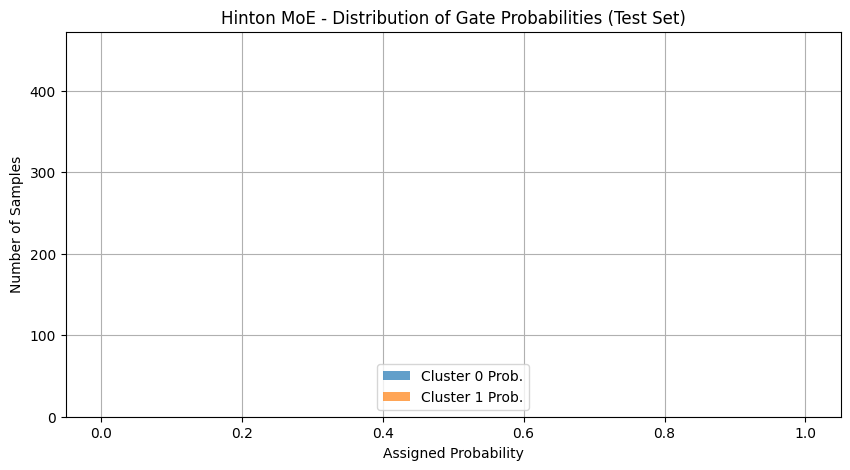

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


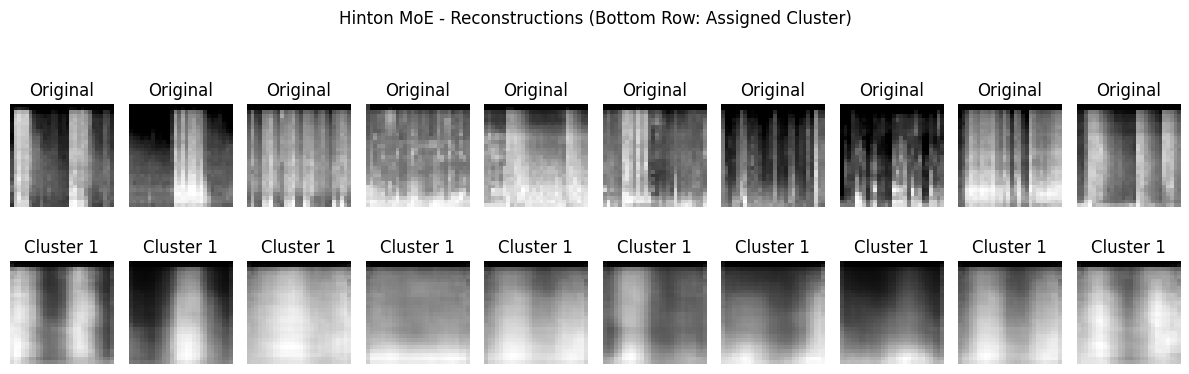

Percentage of True Labels within each Predicted Cluster for Hinton MoE:


,Cluster 1
TrueLabel,
0,42.51
1,57.49





 Evaluating Model: MoA+ 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

 Final Validation MSE (from history): 0.009823
NMI: 0.0892


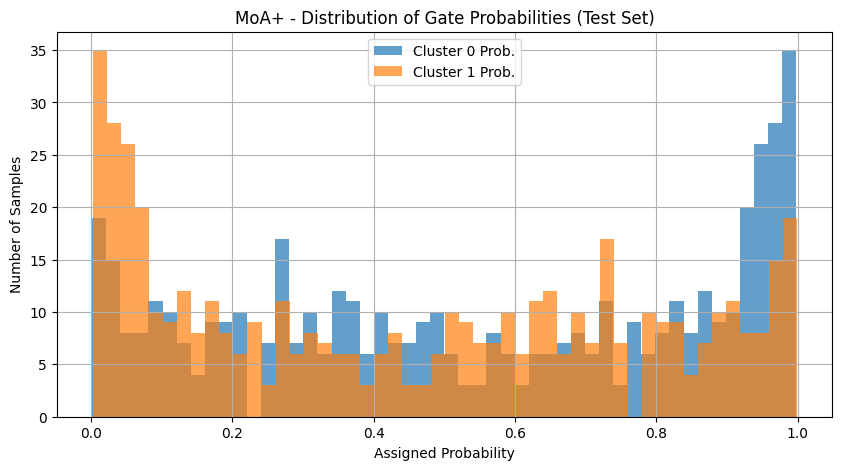

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


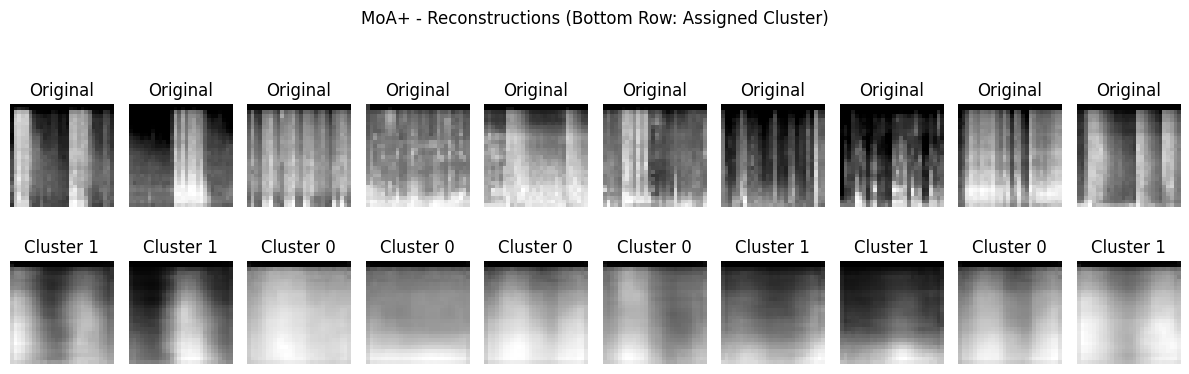

Percentage of True Labels within each Predicted Cluster for MoA+:


,Cluster 0,Cluster 1
TrueLabel,,
0,26.36,60.7
1,73.64,39.3


In [49]:
models_dict = {
    "Hinton MoE": (hinton_model, hinton_history),
    "MoA+": (moa_plus_model, moa_plus_model_history)
}

n_images_to_show = 10
indices_to_show = np.random.choice(x_test.shape[0], n_images_to_show, replace=False)
x_test_sample = x_test[indices_to_show]

for model_name, (model, history) in models_dict.items():
    print(f"\n Evaluating Model: {model_name} \n")

    all_assignments = model.get_cluster_assignments(x_test).numpy()
    gate_probs_test = model.gate.predict(x_test, batch_size=BATCH_SIZE)
    if isinstance(gate_probs_test, tf.Tensor):
        gate_probs_test = gate_probs_test.numpy()

    final_val_mse = history.history['val_loss'][-1]
    print(f"\n Final Validation MSE (from history): {final_val_mse:.6f}")
    nmi_score = normalized_mutual_info_score(y_test, all_assignments)
    print(f"NMI: {nmi_score:.4f}")


    plt.figure(figsize=(10, 5))
    for k in range(NUM_CLUSTERS):
        plt.hist(gate_probs_test[:, k], bins=50, alpha=0.7, label=f'Cluster {k} Prob.')
    plt.title(f'{model_name} - Distribution of Gate Probabilities (Test Set)')
    plt.xlabel('Assigned Probability')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(True)
    plt.show()
  



    reconstructions_sample = model.predict(x_test_sample, batch_size=BATCH_SIZE)
    assignments_sample = all_assignments[indices_to_show] # Use assignments already calculated

    plt.figure(figsize=(12, 4))
    for i in range(n_images_to_show):
        ax = plt.subplot(2, n_images_to_show, i + 1)
        plt.imshow(x_test_sample[i], cmap='gray')
        plt.title(f"Original")
        plt.axis('off')
        ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
        plt.imshow(reconstructions_sample[i], cmap='gray')
        plt.title(f"Cluster {assignments_sample[i]}") # Caption with assigned cluster
        plt.axis('off')
    plt.suptitle(f'{model_name} - Reconstructions (Bottom Row: Assigned Cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

    df_clusters = pd.DataFrame({'TrueLabel': y_test, 'PredictedCluster': all_assignments})
    ct = pd.crosstab(df_clusters['TrueLabel'], df_clusters['PredictedCluster'])
    ct_percent = ct.apply(lambda x: x / x.sum() * 100, axis=0)

    ct_percent = ct_percent.round(2)
    ct_percent.columns = [f'Cluster {col}' for col in ct_percent.columns]

    print(f"Percentage of True Labels within each Predicted Cluster for {model_name}:")
    display(ct_percent)


    print("\n" + "="*50 + "\n")